# PCR and PLS Analysis

* **PCR (Principal Component Regression)**: It is based on the idea of estabilishing a regression model for the resulting components after dimension reduction is applied to variables.

* **PLS (Partial Least Squares Regression)**: It is based on idea of estabilishing a regression model by reducing the variables to a smaller number of components that  do not have multicollinearity problems between them.

# Import Necessary Libraries

In [44]:
# General Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Notebook Settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

# Import Dataset

In [2]:
hitters = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/Hitters.csv")
df = hitters.copy()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5000,N


# General Information  About to Dataset

In [3]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
check_df(df)

######################### Head #########################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors   Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20      NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10 475.0000         N
2    479   130     18    66   72     76      3    1624    457      63    224   266     263      A        W      880       82      14 480.0000         A
3    496   141     20    65   78     37     11    5628   1575     225    828   838     354      N        E      200       11       3 500.0000         N
4    321    87     10    39   42     30      2     396    101      12     48    46      33      N        E      805       40       4  91.5000         N
######################### Tail 

# Analysis of Categorical and Numerical Variables

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car, num_but_cat

In [6]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")
print(f"Num_but_cat: {len(num_but_cat)}")

Observations: 322
Variables: 20
Cat_cols: 3
Num_cols: 17
Cat_but_car: 0
Num_but_cat: 0


In [7]:
def cat_summary(dataframe,col_name,plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      'Ration': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("##########################################")
  if plot:
    sns.countplot(x=dataframe[col_name],data=dataframe)
    plt.show(block=True)

In [8]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in cat_cols:
    cat_summary(dataframe, col, plot=True)

   League  Ration
A     175 54.3478
N     147 45.6522
##########################################


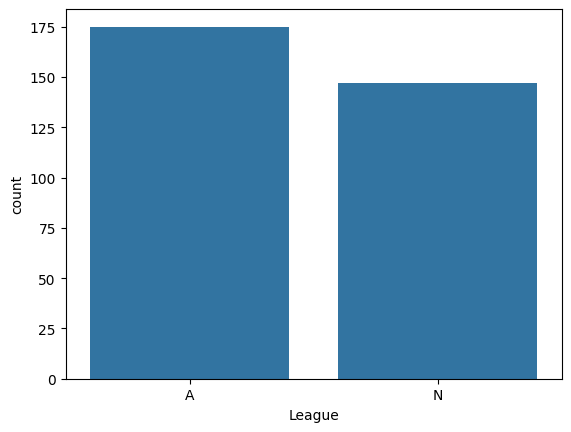

   Division  Ration
W       165 51.2422
E       157 48.7578
##########################################


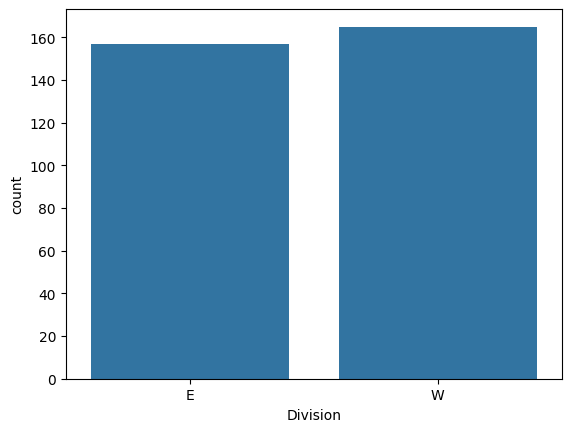

   NewLeague  Ration
A        176 54.6584
N        146 45.3416
##########################################


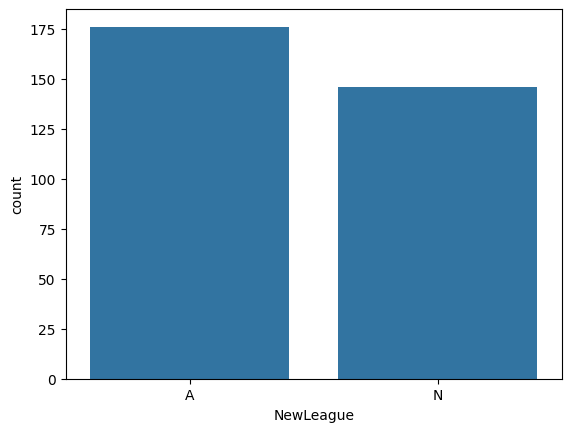

In [9]:
cat_summary_df(df)

In [10]:
def num_summary(dataframe, num_col, plot=False):
  print(50*"#", num_col ,50*"#")
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.ylabel(num_col)
    plt.show(block=True)

In [11]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

################################################## AtBat ##################################################
count   322.0000
mean    380.9286
std     153.4050
min      16.0000
1%       20.4200
5%      161.0000
10%     194.1000
20%     221.8000
30%     281.3000
40%     321.8000
50%     379.5000
60%     430.2000
70%     490.0000
80%     535.6000
90%     584.9000
95%     609.9000
99%     658.5900
max     687.0000
Name: AtBat, dtype: float64


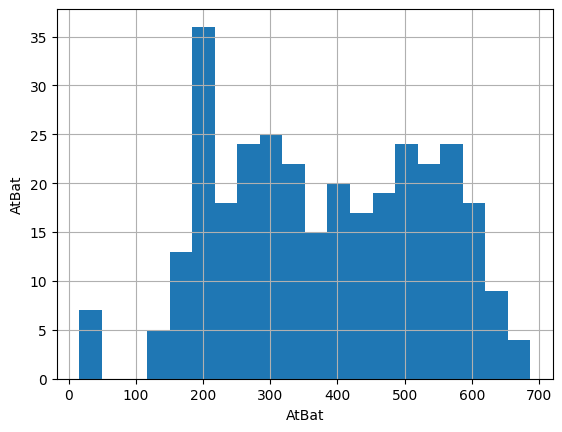

################################################## Hits ##################################################
count   322.0000
mean    101.0248
std      46.4547
min       1.0000
1%        4.4200
5%       39.0000
10%      45.1000
20%      57.0000
30%      70.0000
40%      82.0000
50%      96.0000
60%     113.0000
70%     128.7000
80%     144.0000
90%     163.0000
95%     174.0000
99%     210.7900
max     238.0000
Name: Hits, dtype: float64


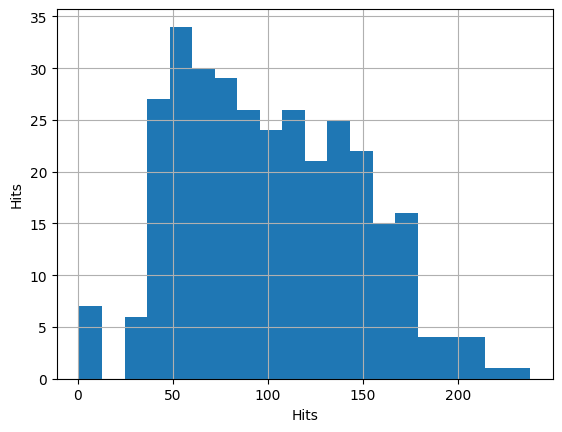

################################################## HmRun ##################################################
count   322.0000
mean     10.7702
std       8.7090
min       0.0000
1%        0.0000
5%        0.0000
10%       1.0000
20%       3.0000
30%       5.0000
40%       6.0000
50%       8.0000
60%      10.6000
70%      14.0000
80%      18.0000
90%      24.0000
95%      28.9500
99%      33.0000
max      40.0000
Name: HmRun, dtype: float64


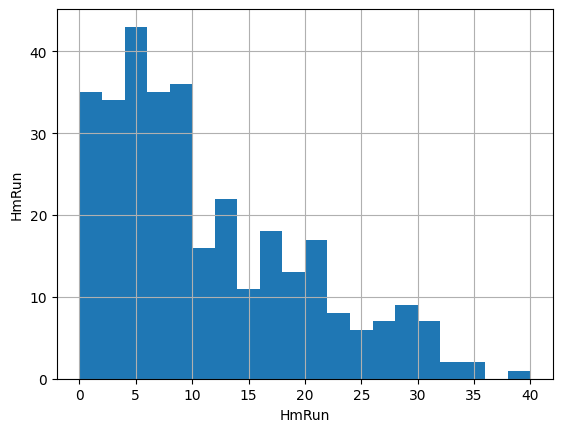

################################################## Runs ##################################################
count   322.0000
mean     50.9099
std      26.0241
min       0.0000
1%        1.2100
5%       17.0000
10%      20.1000
20%      27.0000
30%      33.0000
40%      41.0000
50%      48.0000
60%      55.6000
70%      66.0000
80%      75.8000
90%      89.0000
95%      94.0000
99%     107.7900
max     130.0000
Name: Runs, dtype: float64


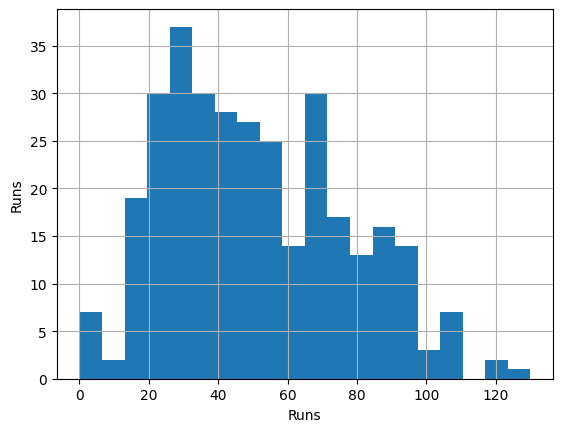

################################################## RBI ##################################################
count   322.0000
mean     48.0280
std      26.1669
min       0.0000
1%        2.0000
5%       14.0000
10%      19.0000
20%      26.0000
30%      30.0000
40%      36.4000
50%      44.0000
60%      49.0000
70%      58.0000
80%      73.0000
90%      86.0000
95%      96.0000
99%     112.3700
max     121.0000
Name: RBI, dtype: float64


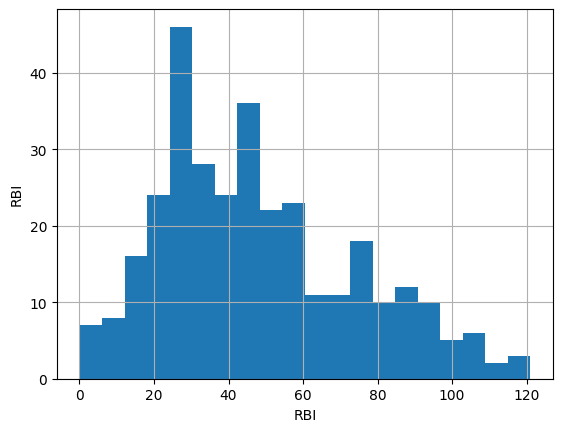

################################################## Walks ##################################################
count   322.0000
mean     38.7422
std      21.6393
min       0.0000
1%        1.0000
5%       11.0500
10%      15.0000
20%      20.0000
30%      24.0000
40%      30.0000
50%      35.0000
60%      40.0000
70%      48.7000
80%      59.0000
90%      69.9000
95%      78.0000
99%      93.5800
max     105.0000
Name: Walks, dtype: float64


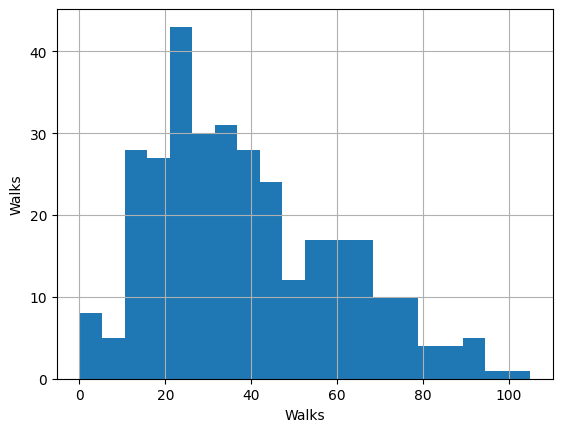

################################################## Years ##################################################
count   322.0000
mean      7.4441
std       4.9261
min       1.0000
1%        1.0000
5%        1.0000
10%       2.0000
20%       3.0000
30%       4.0000
40%       5.0000
50%       6.0000
60%       7.6000
70%      10.0000
80%      12.0000
90%      15.0000
95%      17.0000
99%      19.7900
max      24.0000
Name: Years, dtype: float64


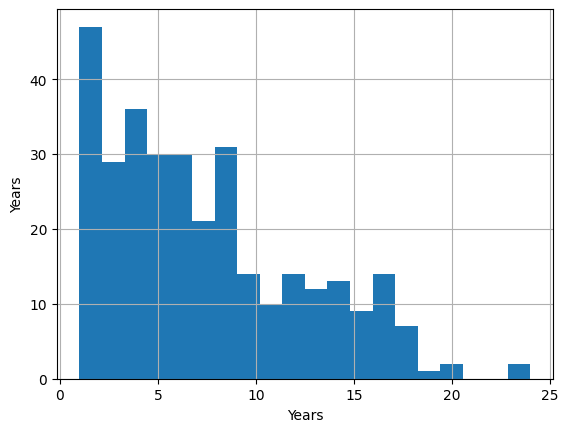

################################################## CAtBat ##################################################
count     322.0000
mean     2648.6832
std      2324.2059
min        19.0000
1%         41.0000
5%        216.5000
10%       342.2000
20%       667.6000
30%       963.4000
40%      1402.2000
50%      1928.0000
60%      2654.0000
70%      3365.0000
80%      4483.0000
90%      6123.4000
95%      7125.6000
99%      8749.9700
max     14053.0000
Name: CAtBat, dtype: float64


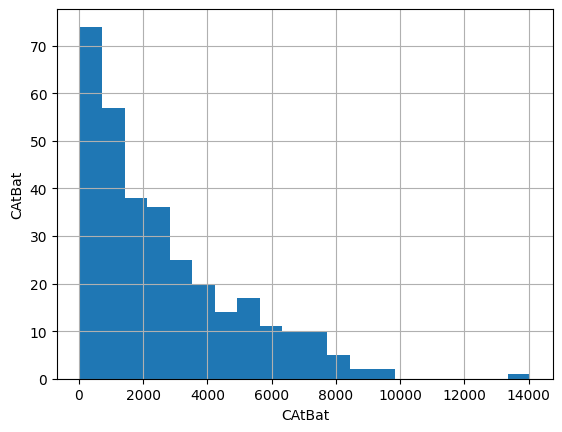

################################################## CHits ##################################################
count    322.0000
mean     717.5714
std      654.4726
min        4.0000
1%         9.8400
5%        54.0000
10%       86.0000
20%      164.6000
30%      238.0000
40%      355.8000
50%      508.0000
60%      708.2000
70%      911.1000
80%     1229.2000
90%     1659.6000
95%     2017.1500
99%     2500.3400
max     4256.0000
Name: CHits, dtype: float64


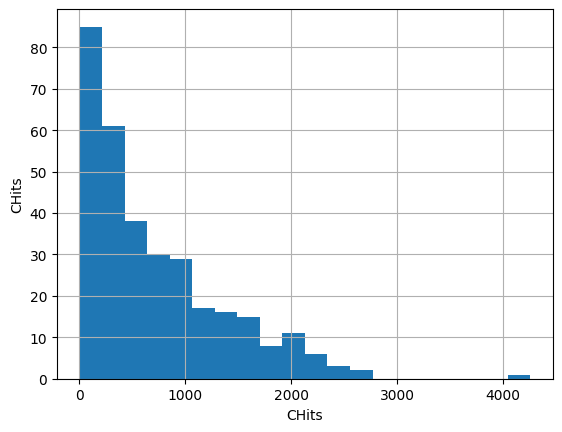

################################################## CHmRun ##################################################
count   322.0000
mean     69.4907
std      86.2661
min       0.0000
1%        0.0000
5%        2.0000
10%       4.0000
20%      10.2000
30%      16.3000
40%      27.4000
50%      37.5000
60%      51.2000
70%      72.4000
80%     103.8000
90%     194.9000
95%     265.6500
99%     373.1200
max     548.0000
Name: CHmRun, dtype: float64


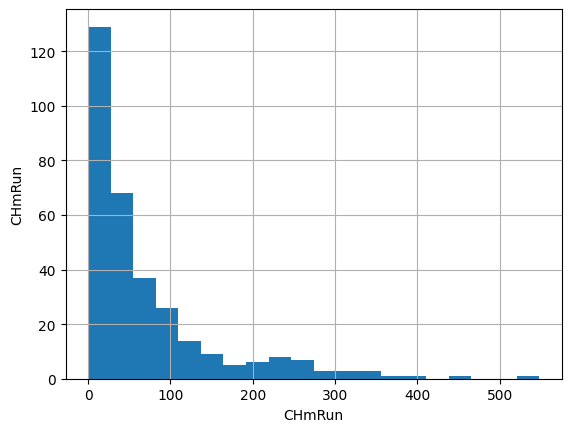

################################################## CRuns ##################################################
count    322.0000
mean     358.7950
std      334.1059
min        1.0000
1%         3.6300
5%        27.0000
10%       38.1000
20%       80.4000
30%      117.3000
40%      181.0000
50%      247.0000
60%      333.0000
70%      443.4000
80%      627.2000
90%      895.7000
95%     1032.3000
99%     1174.3700
max     2165.0000
Name: CRuns, dtype: float64


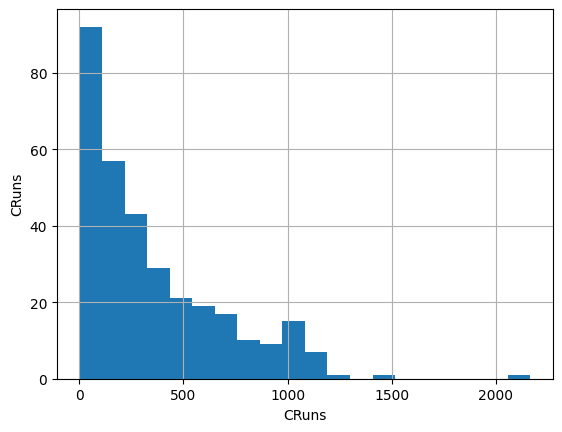

################################################## CRBI ##################################################
count    322.0000
mean     330.1180
std      333.2196
min        0.0000
1%         4.6300
5%        22.0500
10%       34.1000
20%       70.2000
30%      106.3000
40%      149.0000
50%      220.5000
60%      303.6000
70%      379.1000
80%      496.2000
90%      861.6000
95%     1071.7500
99%     1310.8500
max     1659.0000
Name: CRBI, dtype: float64


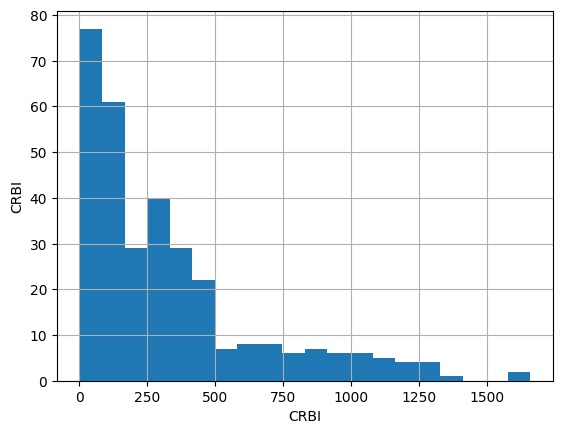

################################################## CWalks ##################################################
count    322.0000
mean     260.2391
std      267.0581
min        0.0000
1%         4.0000
5%        15.0500
10%       30.1000
20%       55.0000
30%       82.0000
40%      117.4000
50%      170.5000
60%      226.6000
70%      300.7000
80%      421.0000
90%      643.9000
95%      817.6000
99%     1139.1400
max     1566.0000
Name: CWalks, dtype: float64


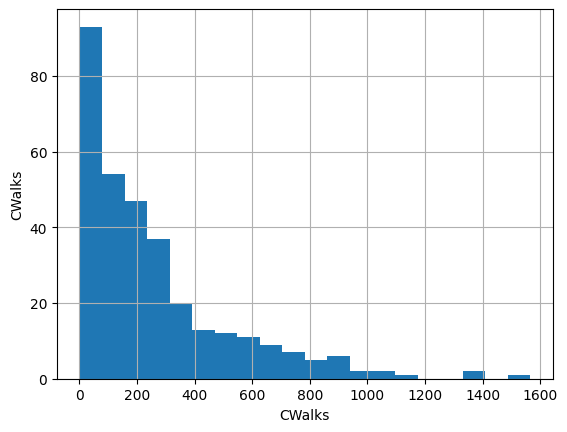

################################################## PutOuts ##################################################
count    322.0000
mean     288.9379
std      280.7046
min        0.0000
1%         0.0000
5%        33.2000
10%       62.2000
20%       99.6000
30%      132.0000
40%      167.0000
50%      212.0000
60%      257.4000
70%      303.0000
80%      365.8000
90%      685.6000
95%      910.6500
99%     1301.1900
max     1378.0000
Name: PutOuts, dtype: float64


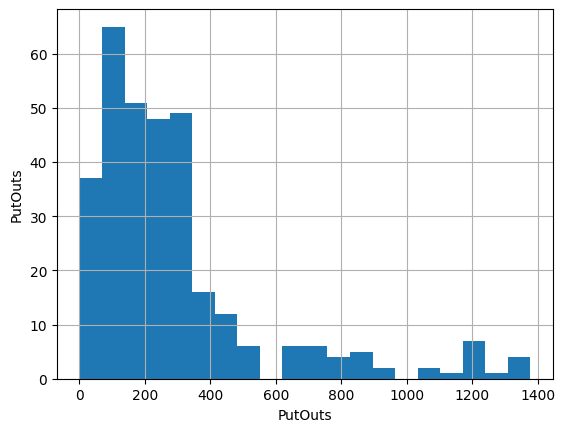

################################################## Assists ##################################################
count   322.0000
mean    106.9130
std     136.8549
min       0.0000
1%        0.0000
5%        0.0000
10%       2.0000
20%       5.2000
30%       9.0000
40%      15.4000
50%      39.5000
60%      76.8000
70%     134.8000
80%     210.8000
90%     353.3000
95%     431.4500
99%     478.1600
max     492.0000
Name: Assists, dtype: float64


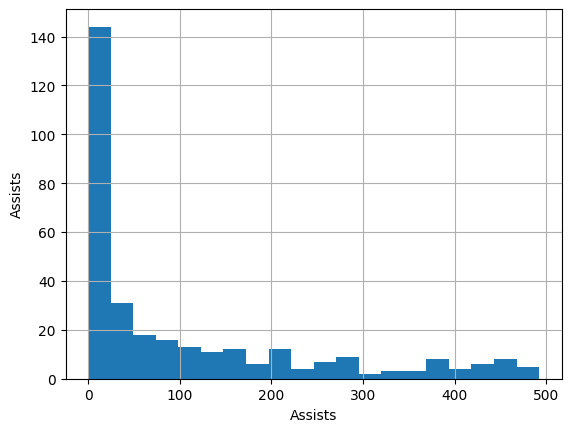

################################################## Errors ##################################################
count   322.0000
mean      8.0404
std       6.3684
min       0.0000
1%        0.0000
5%        0.0000
10%       1.0000
20%       3.0000
30%       4.0000
40%       5.0000
50%       6.0000
60%       8.0000
70%      10.0000
80%      13.0000
90%      17.0000
95%      20.0000
99%      25.7900
max      32.0000
Name: Errors, dtype: float64


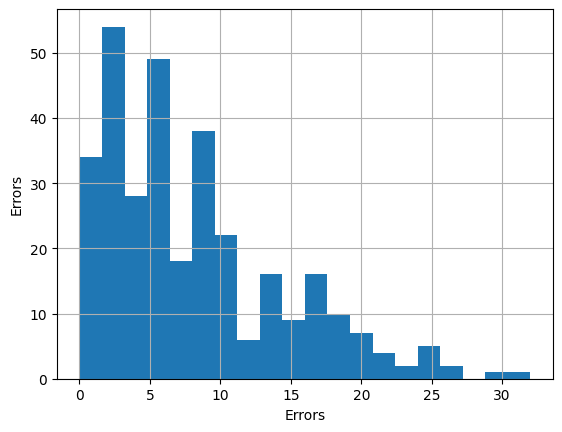

################################################## Salary ##################################################
count    263.0000
mean     535.9259
std      451.1187
min       67.5000
1%        70.0000
5%        86.6000
10%      100.0000
20%      155.0000
30%      221.0000
40%      300.0000
50%      425.0000
60%      538.0000
70%      700.0000
80%      809.0000
90%     1048.6666
95%     1346.0000
99%     2032.8865
max     2460.0000
Name: Salary, dtype: float64


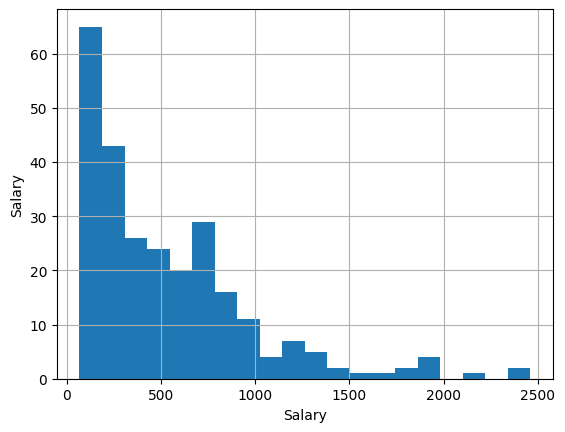

In [12]:
num_summary_df(df)

In [13]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  plt.figure(figsize=(12,4))
  for index, col in enumerate(num_cols):
    plt.subplot(3,6, index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)

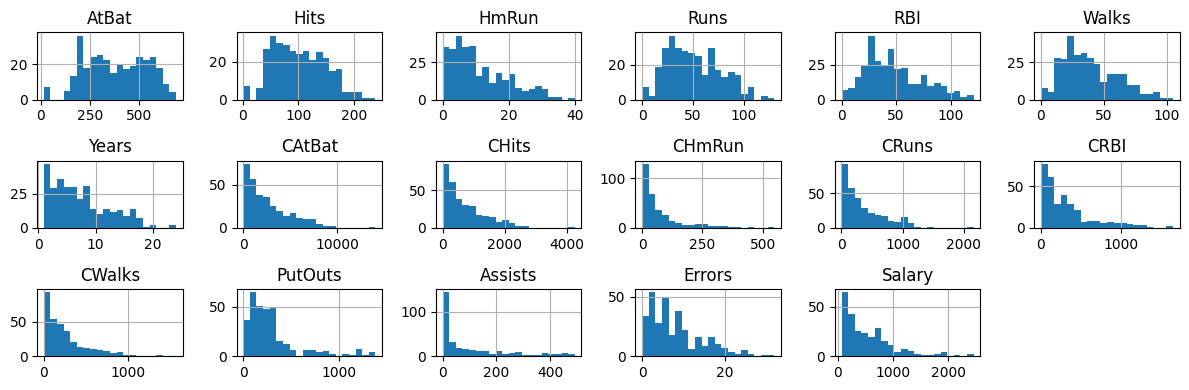

In [14]:
plot_num_summary(df)

In [15]:
def target_summary_with_cat(dataframe, target, categorical_col):
  print(f"##################### {target} -> {categorical_col} #####################")
  print(pd.DataFrame({"Target Mean": dataframe.groupby(categorical_col)[target].mean()}))

In [16]:
def target_summary_with_cat_df(dataframe, target):
    cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
    for col in cat_cols:
        target_summary_with_cat(dataframe, target, col)

In [17]:
target_summary_with_cat_df(df, "Salary")

##################### Salary -> League #####################
        Target Mean
League             
A          541.9995
N          529.1175
##################### Salary -> Division #####################
          Target Mean
Division             
E            624.2714
W            450.8769
##################### Salary -> NewLeague #####################
           Target Mean
NewLeague             
A             537.1130
N             534.5539


# Correlation Analysis

In [18]:
def correlated_cols(dataframe, plot=False):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
  corr = dataframe[num_cols].corr()
  print(corr)

  if plot:
    sns.set(rc={'figure.figsize': (18,13)})
    sns.heatmap(corr, cmap='magma', annot=True, fmt=".2f")
    plt.show()

         AtBat   Hits   HmRun   Runs    RBI  Walks   Years  CAtBat   CHits  CHmRun   CRuns    CRBI  CWalks  PutOuts  Assists  Errors  Salary
AtBat   1.0000 0.9679  0.5922 0.9131 0.8205 0.6698  0.0474  0.2355  0.2527  0.2367  0.2665  0.2441  0.1661   0.3175   0.3538  0.3521  0.3948
Hits    0.9679 1.0000  0.5622 0.9222 0.8111 0.6412  0.0448  0.2276  0.2558  0.2027  0.2618  0.2320  0.1518   0.3107   0.3205  0.3100  0.4387
HmRun   0.5922 0.5622  1.0000 0.6510 0.8551 0.4810  0.1163  0.2219  0.2206  0.4932  0.2624  0.3520  0.2332   0.2829  -0.1063  0.0393  0.3430
Runs    0.9131 0.9222  0.6510 1.0000 0.7982 0.7322  0.0045  0.1865  0.2048  0.2279  0.2506  0.2060  0.1822   0.2793   0.2206  0.2405  0.4199
RBI     0.8205 0.8111  0.8551 0.7982 1.0000 0.6160  0.1462  0.2947  0.3082  0.4418  0.3233  0.3932  0.2509   0.3432   0.1066  0.1934  0.4495
Walks   0.6698 0.6412  0.4810 0.7322 0.6160 1.0000  0.1365  0.2772  0.2807  0.3325  0.3385  0.3086  0.4245   0.2995   0.1497  0.1294  0.4439
Years   0.047

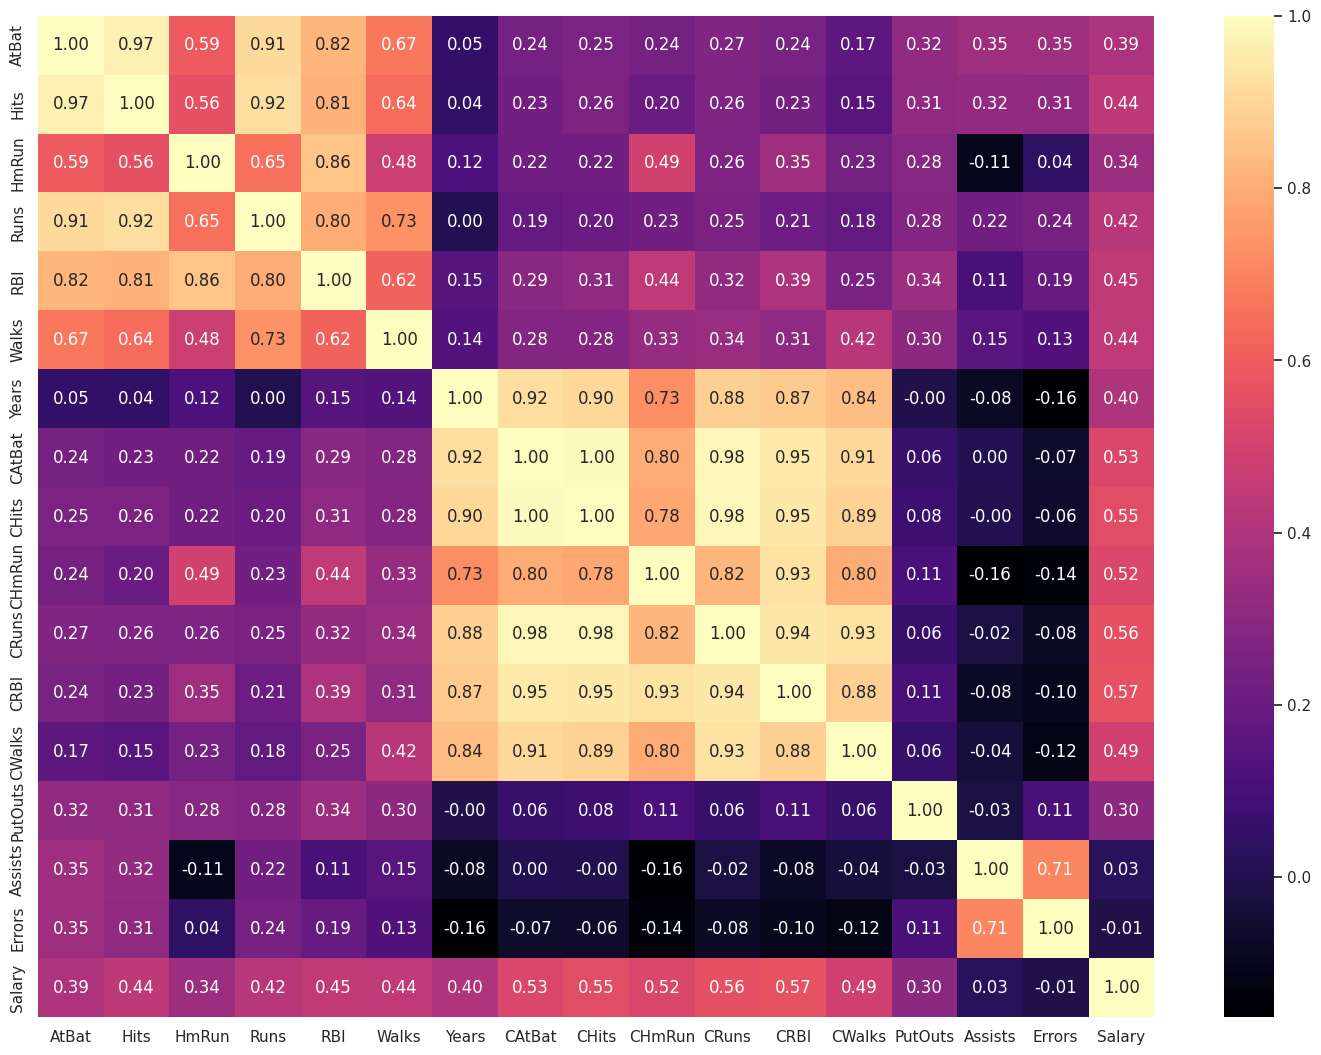

In [19]:
correlated_cols(df, plot=True)

In [42]:
def high_correlated_cols(dataframe, corr_th = 0.90, plot=False):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
  corr = dataframe[num_cols].corr()
  corr_matrix = corr.abs()
  upper_triangular_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  drop_list = [col for col in upper_triangular_matrix.columns if any(upper_triangular_matrix[col] > corr_th)]
  if drop_list == []:
    print("Aftre corelation analysis, we dont need to remove variables")

  if plot:
    sns.set(rc={'figure.figsize': (18,13)})
    sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
    plt.show()

  return drop_list

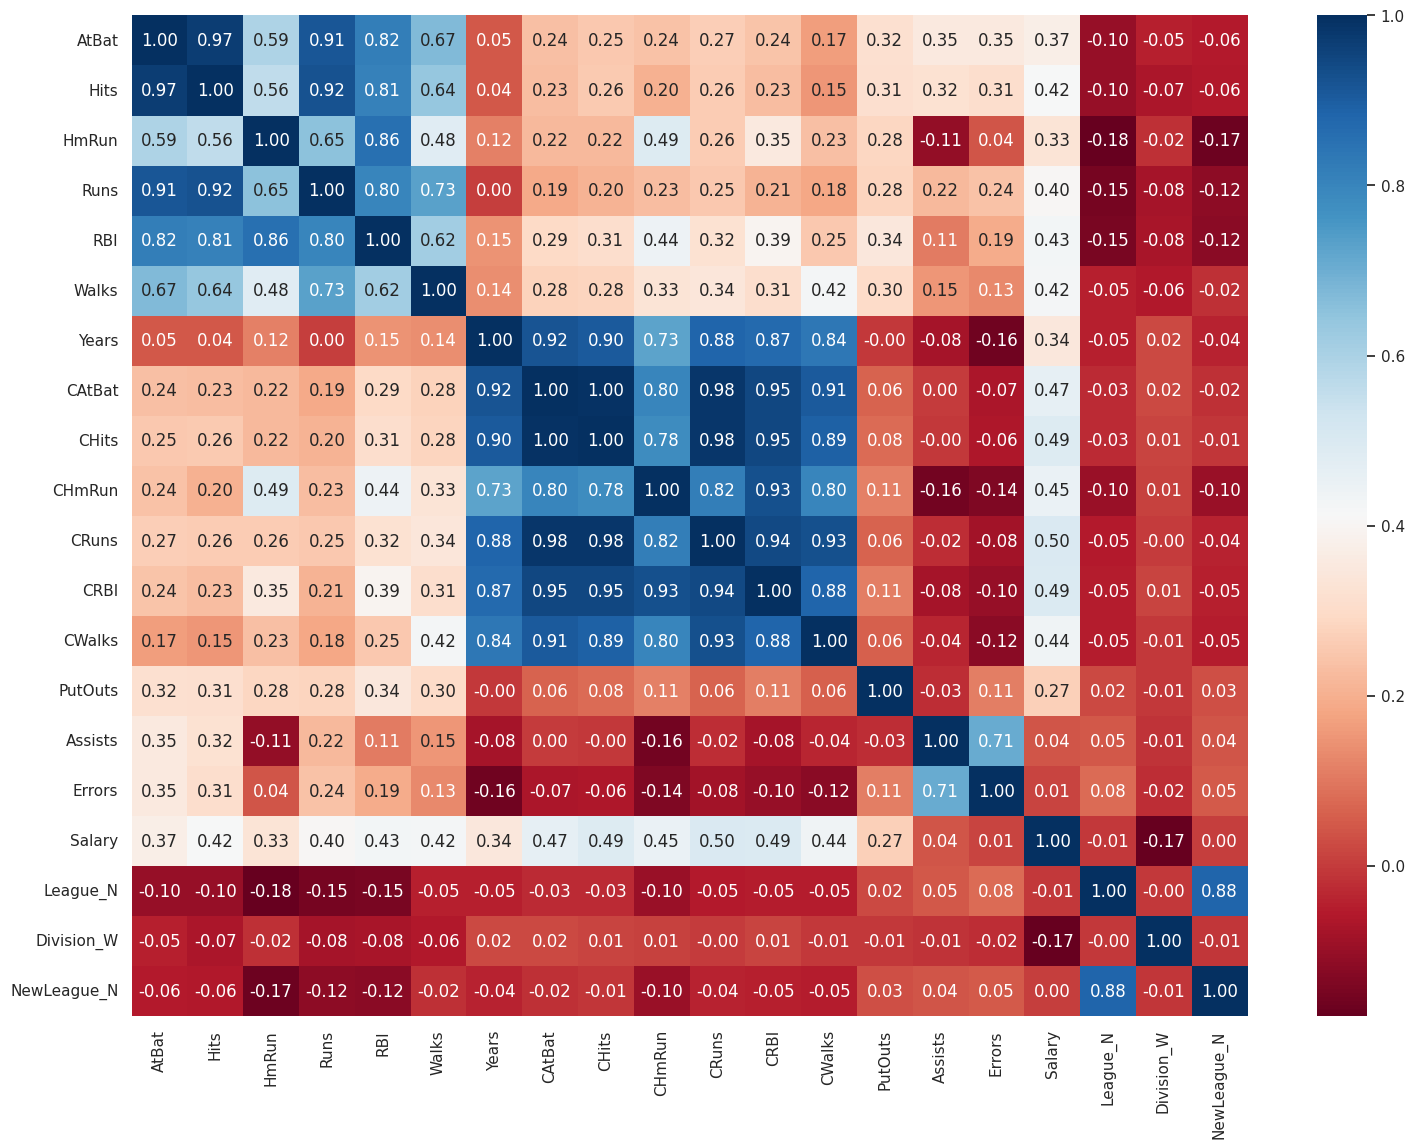

In [43]:
drop_list = high_correlated_cols(df, plot=True)

In [22]:
drop_list

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

# Missing Value Analysis

In [23]:
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [24]:
def missing_value_table(dataframe, na_names=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=["n_miss", "ratio"])
  print(missing_df)

  if na_names:
    print(25*"#", "NA Columns", 25*"#")
    return na_columns

In [25]:
na_columns = missing_value_table(df, na_names=True)

        n_miss   ratio
Salary      59 18.3200
######################### NA Columns #########################


In [26]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [27]:
df = fill_na_with_median(df)

In [28]:
df.isnull().sum().sum()

0

# Encoding

In [29]:
def one_hot_encoding(dataframe, drop_first=True):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
  return dataframe

In [30]:
df = one_hot_encoding(df)

In [31]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20,425.0000,0,0,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0000,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0000,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0000,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5000,1,0,1


# Scaling

In [32]:
def robust_scaler_dataframe(dataframe):
  temp_df = dataframe.copy()
  rs = RobustScaler()
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in num_cols:
    temp_df[col] = rs.fit_transform(temp_df[[col]])
  return temp_df

In [33]:
df = robust_scaler_dataframe(df)

# PCR (Principal Component Regression)

It is based on the idea of estabilishing a regression model for the resulting components after dimension reduction is applied to variables.

In [34]:
def PCR_Model(dataframe, target, test_size=0.20, results=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  pca_train = PCA()
  pca_test = PCA()
  X_reduced_train = pca_train.fit_transform(X_train)
  X_reduced_test = pca_test.fit_transform(X_test)
  lm = LinearRegression()
  pcr_model = lm.fit(X_reduced_train, y_train)

  if results:
    mse_train = mean_squared_error(y_train, pcr_model.predict(X_reduced_train))
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_test, pcr_model.predict(X_reduced_test))
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, pcr_model.predict(X_reduced_train))
    mae_test = mean_absolute_error(y_test, pcr_model.predict(X_reduced_test))
    r2_train = r2_score(y_train, pcr_model.predict(X_reduced_train))
    r2_test = r2_score(y_test, pcr_model.predict(X_reduced_test))
    print("Reduced Features Train(Ratio): ", np.cumsum(np.round(pca_train.explained_variance_ratio_, decimals=4)*100))
    print("Reduced Features Test(Ratio): ", np.cumsum(np.round(pca_test.explained_variance_ratio_, decimals=4)*100))
    print("MSE_train: ", "%.3f" % mse_train)
    print("RMSE_train: ", "%.3f" % rmse_train)
    print("MSE_test: ", "%.3f" % mse_test)
    print("RMSE_test: ", "%.3f" % rmse_test)
    print("MAE_train: ", "%.3f" % mae_train)
    print("MAE_test: ", "%.3f" % mae_test)
    print("R2_train: ", "%.3f" % r2_train)
    print("R2_test: ", "%.3f" % r2_test)

  return pcr_model

In [35]:
pcr_model = PCR_Model(df, "Salary", results=True)

Reduced Features Train(Ratio):  [42.32 64.15 76.02 84.15 88.09 91.34 93.48 95.6  97.03 98.07 98.62 99.02
 99.35 99.62 99.79 99.89 99.96 99.98 99.99]
Reduced Features Test(Ratio):  [51.18 65.58 75.77 84.37 88.6  91.68 94.02 95.73 97.29 98.33 98.95 99.28
 99.58 99.74 99.84 99.92 99.97 99.99 99.99]
MSE_train:  0.372
RMSE_train:  0.610
MSE_test:  0.929
RMSE_test:  0.964
MAE_train:  0.447
MAE_test:  0.621
R2_train:  0.434
R2_test:  0.135


In [36]:
def PCR_Model_Tuning(dataframe, target, n_splits=10, test_size=0.20, results=False, plot=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  pca_train = PCA()
  pca_test = PCA()
  X_reduced_train = pca_train.fit_transform(X_train)
  X_reduced_test = pca_test.fit_transform(X_test)
  lm = LinearRegression()
  cv = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=1)
  RMSE = []
  for i in np.arange(1, X_reduced_train.shape[1]+1):
    score = np.sqrt(-1*model_selection.cross_val_score(lm, X_reduced_train[:,:i], y_train.ravel(),
                                                       cv=cv, scoring="neg_mean_squared_error").mean())
    RMSE.append(score)

  min_RMSE_index = np.argmin(RMSE)
  lm = LinearRegression()
  pcr_model = lm.fit(X_reduced_train[:,0:min_RMSE_index], y_train)

  if results:
    mse_train = mean_squared_error(y_train, pcr_model.predict(X_reduced_train[:,0:min_RMSE_index]))
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_test, pcr_model.predict(X_reduced_test[:,0:min_RMSE_index]))
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, pcr_model.predict(X_reduced_train[:,0:min_RMSE_index]))
    mae_test = mean_absolute_error(y_test, pcr_model.predict(X_reduced_test[:,0:min_RMSE_index]))
    r2_train = r2_score(y_train, pcr_model.predict(X_reduced_train[:,0:min_RMSE_index]))
    r2_test = r2_score(y_test, pcr_model.predict(X_reduced_test[:,0:min_RMSE_index]))
    print("MSE_train: ", "%.3f" % mse_train)
    print("RMSE_train: ", "%.3f" % rmse_train)
    print("MSE_test: ", "%.3f" % mse_test)
    print("RMSE_test: ", "%.3f" % rmse_test)
    print("MAE_train: ", "%.3f" % mae_train)
    print("MAE_test: ", "%.3f" % mae_test)
    print("R2_train: ", "%.3f" % r2_train)
    print("R2_test: ", "%.3f" % r2_test)

  if plot:
    plt.figure(figsize=(6,4))
    plt.plot(RMSE,'-v')
    plt.xlabel("Number of Components")
    plt.ylabel("RMSE")
    plt.title("PCR Model Tuning")

  return RMSE

MSE_train:  0.475
RMSE_train:  0.689
MSE_test:  0.753
RMSE_test:  0.868
MAE_train:  0.494
MAE_test:  0.563
R2_train:  0.276
R2_test:  0.299


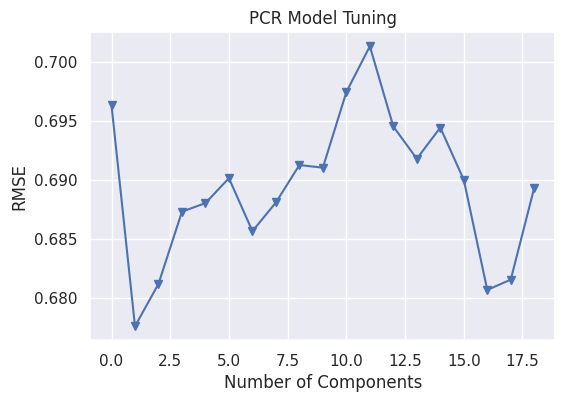

In [37]:
RMSE = PCR_Model_Tuning(df, "Salary", results=True, plot=True)

# PLS (Partial Least Squares)

It is based on idea of estabilishing a regression model by reducing the variables to a smaller number of components that do not have multicollinearity problems between them.

In [70]:
def PLS_Model(dataframe, target, test_size=0.20, results=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  lm = PLSRegression()
  pls_model = lm.fit(X_train, y_train)

  if results:
    mse_train = mean_squared_error(y_train, pls_model.predict(X_train))
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_test, pls_model.predict(X_test))
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, pls_model.predict(X_train))
    mae_test = mean_absolute_error(y_test, pls_model.predict(X_test))
    r2_train = r2_score(y_train, pls_model.predict(X_train))
    r2_test = r2_score(y_test, pls_model.predict(X_test))
    print("MSE_train: ", "%.3f" % mse_train)
    print("RMSE_train: ", "%.3f" % rmse_train)
    print("MSE_test: ", "%.3f" % mse_test)
    print("RMSE_test: ", "%.3f" % rmse_test)
    print("MAE_train: ", "%.3f" % mae_train)
    print("MAE_test: ", "%.3f" % mae_test)
    print("R2_train: ", "%.3f" % r2_train)
    print("R2_test: ", "%.3f" % r2_test)

  return pls_model

In [71]:
pls_model = PLS_Model(df, "Salary", results=True)

MSE_train:  0.429
RMSE_train:  0.655
MSE_test:  0.607
RMSE_test:  0.779
MAE_train:  0.461
MAE_test:  0.549
R2_train:  0.346
R2_test:  0.435


In [87]:
def PLS_Model_Tuning(dataframe, target, n_splits=10, test_size=0.20, results=False, plot=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  cv = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=1)
  RMSE = []
  for i in np.arange(1, X_train.shape[1]+1):
    pls = PLSRegression(n_components=i)
    score = np.sqrt(-1*model_selection.cross_val_score(pls, X_train, y_train,
                                                       cv=cv, scoring="neg_mean_squared_error").mean())
    RMSE.append(score)

  min_RMSE_index = np.argmin(RMSE)
  lm = PLSRegression(n_components=min_RMSE_index)
  pls_model = lm.fit(X_train, y_train)

  if results:
    mse_train = mean_squared_error(y_train, pls_model.predict(X_train))
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_test, pls_model.predict(X_test))
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, pls_model.predict(X_train))
    mae_test = mean_absolute_error(y_test, pls_model.predict(X_test))
    r2_train = r2_score(y_train, pls_model.predict(X_train))
    r2_test = r2_score(y_test, pls_model.predict(X_test))
    print("MSE_train: ", "%.3f" % mse_train)
    print("RMSE_train: ", "%.3f" % rmse_train)
    print("MSE_test: ", "%.3f" % mse_test)
    print("RMSE_test: ", "%.3f" % rmse_test)
    print("MAE_train: ", "%.3f" % mae_train)
    print("MAE_test: ", "%.3f" % mae_test)
    print("R2_train: ", "%.3f" % r2_train)
    print("R2_test: ", "%.3f" % r2_test)

  if plot:
    plt.figure(figsize=(6,4))
    plt.plot(RMSE,'-v')
    plt.xlabel("Number of Components")
    plt.ylabel("RMSE")
    plt.title("PCR Model Tuning")

  return RMSE

MSE_train:  0.375
RMSE_train:  0.613
MSE_test:  0.591
RMSE_test:  0.769
MAE_train:  0.447
MAE_test:  0.561
R2_train:  0.428
R2_test:  0.450


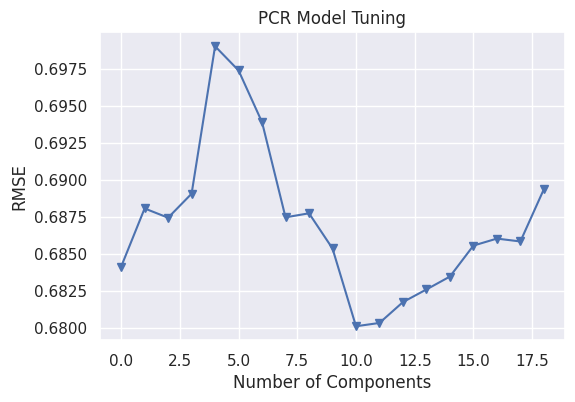

In [88]:
RMSE = PLS_Model_Tuning(df, "Salary", results=True, plot=True)